<a id="top"></a> 
# Analysis of rhythmic activity *for the practicing neuroscientist*

<div class="alert alert-block alert-info">
_**Synopsis**_ <br><br>

**Data:** Field data: 1 s of ECoG data sampled at 500 Hz.
<br>

**Goal:** Characterize the observed rhythms in these data.
<br>

**Tools:** Fourier transform, power spectral density, spectrogram.
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    1. [Visual inspection](#visual-inspection)
    2. [Spectral Analysis: The Rectangular Taper and Zero Padding](#rect-tapers)
    3. [Beyond the Rectangular Taper—the Hanning Taper](#hann-taper)
    4. [Beyond the Hanning Taper—the Multitaper Method](#multitaper)
    5. [Confidence Intervals of the Spectrum](#ci)
* [Summary](#summary)
* [Appendix: Multiplication and Convolution in Different Domains](#appendix)

## Introduction
In another chapter, we considered noninvasive recordings of brain electrical activity from the scalp surface using scalp EEG. Although the scalp EEG provides fine temporal resolution of brain activity, the spatial resolution is poor because of the low conductivity of the skull [[Nunez & Srinivasan, 2005](http://www.oxfordscholarship.com/view/10.1093/acprof:oso/9780195050387.001.0001/acprof-9780195050387)]. An alternative, invasive approach to improve the spatial resolution of the scalp EEG is to record directly from the brain’s surface [[Engel, Moll, Fried, & Ojemann, 2005](https://www.ncbi.nlm.nih.gov/pubmed/15611725)]. This technique, known as electrocorticogram (ECoG), eliminates the distorting spatial blurring effect of the skull at the cost of an invasive surgical procedure of implantation.

### Case study data
A patient with epilepsy is scheduled to undergo resective surgery to remove the portion of her brain causing recurrent, unprovoked seizures. As part of her clinical workup, electrodes are implanted beneath the skull, directly on the brain’s surface. We assume that our skilled neurosurgeon collaborator expertly implants the ECoG electrode, and that the ECoG data are collected with no artifacts. We receive from our clinical collabor a 1 s segment of ECoG data recorded from a single electrode and sampled at 500 Hz. 

### Goals
Our collaborator would like to know what rhythms appear in these invasive brain voltage recordings. Our goal is to analyze the 1 s of ECoG data by characterizing the rhythmic attributes of the activity. To do so, we build upon the spectral analysis techniques developed in [Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb).

### Tools
In this notebook, we continue to develop understanding of the Fourier transform and spectrum. We apply the techniques introduced in [Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb) to compute the spectrum. We also investigate the impact of windowing and zero padding on the spectrum, and explain how to apply and interpret the multitaper method.

## Data analysis<a id="data-analysis"></a>

As always, we begin by looking at the data. We load the ECoG data into Python and plot them by issuing the following commands: 

In [1]:
# Prepare the modules and plot settings
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (12,3)

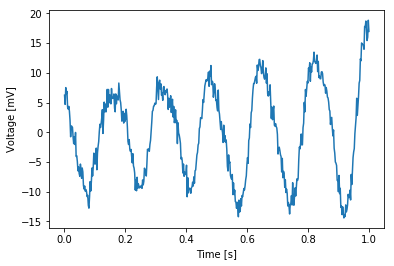

In [2]:
data = sio.loadmat('Ch4-ECoG-1.mat')  # Load the ECoG data
ecog = data['ECoG'].reshape(-1)  # Extract the ECoG variable
t = data['t'][0]  # ... and the t variable

plot(t, ecog)  # Plot the data versus time
xlabel('Time [s]')  # Label the time axis
ylabel('Voltage [mV]')  # ... and the voltage axis
show()

You might notice a dominant rhythmic activity. We can approximate the frequency of this rhythm by counting the number of oscillations that occur in the 1 s interval. To do so, we may approximate the total number of large-amplitude cycles that we observe in the data. Through visual inspection, we find that the first large-amplitude cycle occurs between $\approx$ 0 s and $\approx$ 0.175 s, the next between $\approx$ 0.175 s and $\approx$ 0.3 s, and so on. Counting this way, we approximate 6 full cycles per second, or a dominant 6 Hz rhythm.

<a id="rect-tapers"></a>
### Spectral Analysis: The Rectangular Taper and Zero Padding

Visual inspection, although essential to data analysis, is usually not enough. Visual inspection often guides intuition and reveals major features of the data, but it may also lead us astray; initial looks can be deceiving. To further explore the rhythmic activity of the ECoG data, we compute the spectrum.<sup><abbr title="We could instead write the sample spectrum because we use the observed data to estimate the theoretical spectrum that we would see if we kept repeating this experiment. However, this distinction is not essential to the discussion here.">note</abbr></sup> We do so using the same approach implemented in [Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb). The code is nearly the same:
<a id="fig:4-2a"></a>

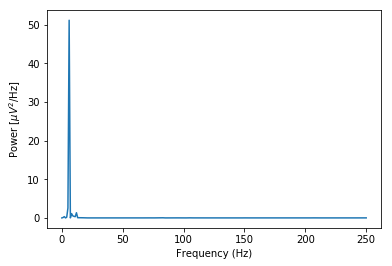

In [3]:
import numpy as np
x = ecog          # Relabel the data variable
dt = t[2] - t[1]  # Define the sampling interval
T = t[-1]         # ... and duration of data

xf = np.fft.rfft(x - x.mean())
Sxx = np.real(2 * dt ** 2 / T * (xf * np.conj(xf)))

df = 1 / T
fNQ = 1 / dt / 2
faxis = np.arange(len(Sxx)) * df
plot(faxis, Sxx)
xlabel('Frequency (Hz)')
ylabel('Power [$\mu V^2$/Hz]')
show()

<div class="alert alert-block alert-info">
**Q.** For the ECoG data considered here, what is the frequency resolution $df$, and what is the Nyquist frequency ($f_{NQ}$)? Compare your answers to the variables ``df`` and ``fNQ`` defined in the code. 
</div>

<div class="alert alert-block alert-info">
**Q.** Interpret the spectrum of the ECoG data. What rhythms appear? 
</div>

The plot of the spectrum suggests a single dominant frequency near 6 Hz, consistent with the visual inspection of the ECoG trace (<a href="#fig:4-1" class="fig">figure<span><img src="imgs/4-1.png"></span></a>). Other interesting structure may also appear, perhaps at frequencies near 10 Hz; note the tiny peak barely visible in the spectrum. These initial observations suggest we can more appropriately scale the spectrum to emphasize both the low-frequency bands and weaker signals. Let’s utilize a logarithmic scale for both the power spectral density (decibels) and the frequency.

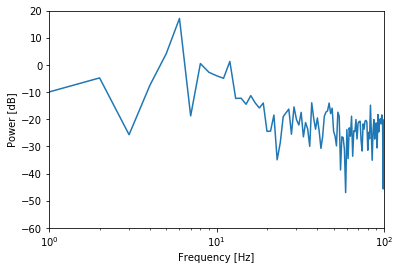

In [4]:
plt.semilogx(faxis, 10 * np.log10(Sxx))  # Plot spectrum vs frequency,
plt.xlim([1, 100])  # ... in select frequency range,
plt.ylim([-60, 20])  # ... and power range,
xlabel('Frequency [Hz]')  # ... with axes labeled.
ylabel('Power [dB]')
show()

<div class="alert alert-block alert-info">
<p>
**Q.** Are the terms *frequency resolution*, *Nyquist frequency*, *Fourier transform*, *decibel*, and *spectrum* familiar? Can you define or explain each term?
</p>

<p>
**A.** If not, we recommend reviewing the case study in [Analysis of Rhythmic Activity of the Scalp EEG](../Analysis of Rhythmic Activity in the Scalp EEG/Analysis of rhythmic activity in the Scalp EEG.ipynb).
</p>
</div>

#### By Doing Nothing, We're Doing Something: The Rectangular Taper.
ECoG time series continue for long durations. For example, an individual’s brain voltage activity may persist for over 90 years, from birth until death. However, ECoG recordings are finite, limited by convenience, technology, or other factors. In the example here, we consider 1 s of ECoG data. Performing this finite observation (lasting 1 s) on a long duration (i.e., 90-year) time series can be understood as a rectangular taper. A rectangular taper multiplies the observed data by 1 and the unobserved data by 0. 
<a id="fig:4-3"></a>
![Example of rectangular taper application.](imgs/4-3.png "Example of rectangular taper application. Raw data continue for a long period of time (top). Most of these data are unobserved. Rectangular taper (red) specifies the interval of observation. Multiplying the raw data by the rectangular taper determines the observed ECoG data (bottom).")

We can think of the value 1 as representing the time period when our recording device is operational; activating the ECoG recording device opens the rectangular taper (value 1), and deactivating the ECoG recording device closes the rectangular taper (value 0). The rectangular taper makes explicit our knowledge about the observed data (in this case, the 1 s interval of ECoG) and our ignorance about the unobserved data, which are assigned the value zero. Notice that the rectangular taper looks like a rectangle (red trace in the figure above).

So, by computing the spectrum of 1 s of observed ECoG data, we’re actually computing the spectrum of the product of two functions: the many years of mostly unobserved ECoG data and the rectangular taper. We note that by "doing nothing" we have implicitly made the choice to use the rectangular taper. We have already plotted the resulting spectrum of the observed ECoG data (again, using the default rectangular taper) above (<a href="#fig:4-2a" class="fig">figure<span><img src="imgs/4-2a.png"><img src="imgs/4-2b.png"></span></a>).

#### Exploring the Impact of the Rectangular Taper.
The <a href="#fig:4-3" class="fig">figure<span><img src="imgs/4-3.png"></span></a> above illustrates how the rectangular taper impacts the observed data in the time domain, namely, the taper selects a region of observation. The rectangular taper also impacts the spectrum in the frequency domain. To see this, consider a perfect sinusoid at frequency 10 Hz that in theory continues forever. In this case, the energy concentrates at a single frequency—the frequency of the sinusoid (10 Hz)—and for the (theoretical) case of an infinite sinusoid, the power spectral density is infinite at that frequency. <a id="fig:4-4"></a>
![Example of rectangular taper application to a sinusoid.](imgs/4-4a.png "Example of rectangular taper application to a sinusoid. (a) Infinite sinusoid continues forever in time; energy concentrates at sinusoid’s frequency of 10 Hz. ")
In mathematical language, we say that the spectrum of the infinite sinusoid is a *delta function*. However, we never observe an infinite sinusoid; to do so would require unlimited resources and unlimited time. Instead, let’s assume we observe only 1 s of the sinusoid’s activity; we imagine multiplying the infinite duration sinusoid by a rectangular taper and observing only a finite interval of time.
![Example of rectangular taper application to a sinusoid.](imgs/4-4b.png "Example of rectangular taper application to a sinusoid. (b) Multiplying the infinite duration sinusoid by a rectangular taper (red) yields a sinusoid of finite duration. Spectrum of the resulting signal (black) exhibits features at many frequencies, with peak at 10 Hz.")

<div class="alert alert-block alert-info">
<p>
**Q.** Examine the spectrum of the finite sinusoid (b). What do you see? Is the spectrum concentrated at one frequency (near 10 Hz), as we expected for an infinite sinusoid?
</p>

<p>
**A.** Visual inspection of the spectrum suggests an unexpected result: the spectrum is *not* concentrated at a single frequency. Instead, many peaks appear, centered at the expected frequency (10 Hz) but also spreading into neighboring frequency bands. The culprit responsible for this leakage outside of the 10 Hz peak is the rectangular taper applied to the true infinite-duration sinusoidal signal.
</p>
</div>

To understand further the impact of the rectangular taper, let’s consider the spectrum of the rectangular taper itself.

To compute the spectrum of the rectangular taper, we me series shown in figure 4.5a. In theory, the rectangular taper is infinite, and is preceded and followed by infinite intervals of zeros (i.e., there’s an infinite period in which we do not observe the ECoG data). To represent the infinite extent of the rectangular taper, we add 10 s of zeros to the beginning and end of a 1 s interval of ones. Of course, 10 s of zeros is a poor representation of an infinite interval of time, but it’s sufficient for our purposes here. We note that the rectangular taper consists of two sharp edges, when the observation interval opens and closes (i.e., transitions from 0 to 1, and then back from 1 to 0).



<div class="alert alert-block alert-info">
**Q.** Examine the spectrum of the rectangular window plotted in figure 4.5b. What do you see? At what frequency is the spectrum concentrated?
</div>

In [5]:
t.shape

(500,)

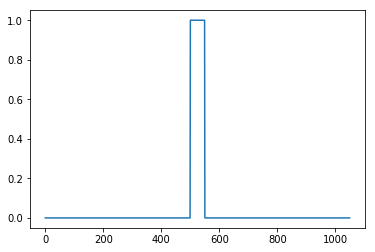

/Users/emilyschlafly/anaconda/envs/csn/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


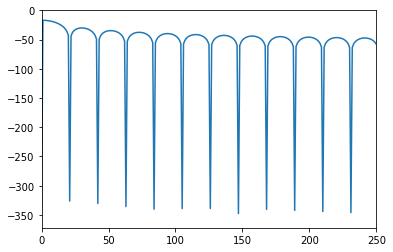

In [6]:
a = np.zeros((50 * 10))
b = np.ones((50))

taper = np.hstack((a,b,a))
plot(taper)
show()

taperf = np.fft.rfft(taper - taper.mean())
Sxx = np.real(2 * dt ** 2 / t.max() * (taperf * np.conj(taperf)))
df = 1 / t.max()
fNQ = 1 / dt / 2
faxis = np.arange(len(Sxx)) * df
plot(faxis, 10 * np.log10(Sxx))
plt.xlim([0, 250])
show()

In [7]:
from IPython.core.display import HTML
HTML('../style.css')